## CS 543 MP3 Part 1
### RANSAC, Homography fitting 

In [10]:
# !pip install opencv-python==3.4.2.16

# !pip install --user opencv-contrib-python==3.4.2.16

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
import skimage
from skimage import img_as_float
from skimage import io
from skimage import color
import PIL
from PIL import Image

In [4]:
dir_name = 'C:\\Users\\Rachneet Kaur\\Desktop\\UIUC\\UIUC Spring 2019\\CS 543 CV\\MP3\\images\\'

In [5]:
#Plotting an image 
def plot_image(image, name = 'image', downsample = False):
    if downsample:
        plt.figure(figsize = (1.5,1.5))
    else:
        plt.figure(figsize = (10,10))
    plt.imshow(image,  cmap = plt.cm.gray)
    plt.savefig(name + '.jpg')

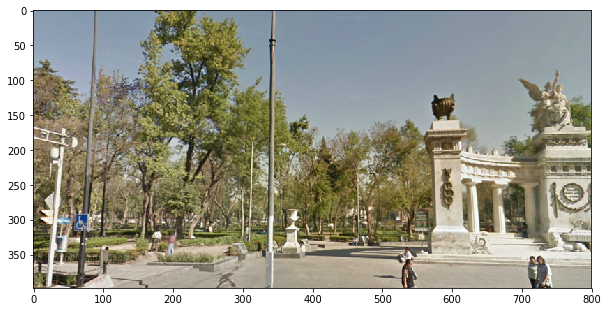

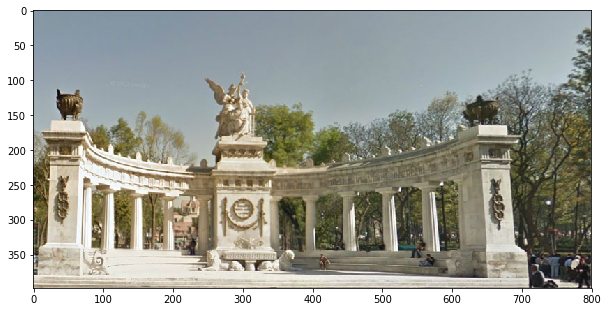

In [6]:
#Given image 1
image1 = Image.open(dir_name + 'left.jpg')
plot_image(image1)

#Given image 2
image2 = Image.open(dir_name + 'right.jpg')
plot_image(image2)

In [7]:
#Converting images to grayscale and extracting the keypoints using SIFT
#Image 1
#Step 1
image1 = cv2.imread(dir_name + 'left.jpg')
image1_gray= cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

#Step 2
sift = cv2.xfeatures2d.SIFT_create()
image1_kp = sift.detect(image1_gray, None) 
image1_sift=cv2.drawKeypoints(image1_gray, image1_kp, None)
 
cv2.imwrite('sift_keypoints_image1.jpg',image1_sift)

#Image 2
image2 = cv2.imread(dir_name + 'right.jpg')
image2_gray= cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
image2_kp = sift.detect(image2_gray, None) 
image2_sift=cv2.drawKeypoints(image2_gray, image2_kp, None)
 
cv2.imwrite('sift_keypoints_image2.jpg', image2_sift)

True

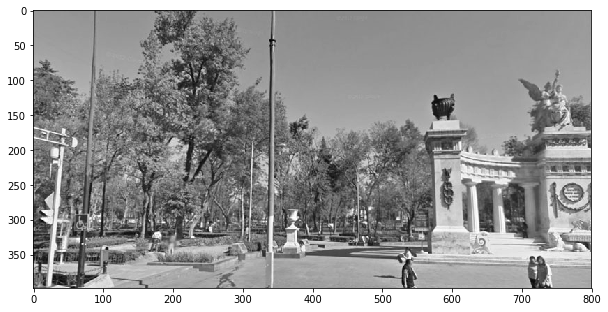

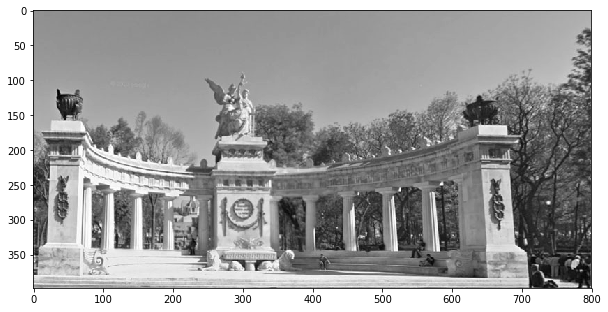

In [8]:
#Plotting the grayscaled images 
plot_image(image1_gray, 'image1_gray')
plot_image(image2_gray, 'image2_gray')

In [9]:
#After extracting the keypoints using SIFT, computing the Descriptors using SIFT
#Step 3
image1_kp, image1_des = sift.compute(image1_gray, image1_kp)
image2_kp, image2_des = sift.compute(image2_gray, image2_kp)

In [10]:
#Converting images to float type
data1 =  np.array(image1_gray, dtype=float)
data2 =  np.array(image2_gray, dtype=float)

In [11]:
#Square of the Euclidean distance between the descriptors of image 1 and image 2
#Step 4
distance_des = scipy.spatial.distance.cdist(image1_des, image2_des, 'sqeuclidean')

In [196]:
#Step 5
def index(a, l):
    i = np.argpartition(a.ravel(), l)
    return tuple(np.array(np.unravel_index(i, a.shape))[:, range(min(l, 0), max(l, 0))])
count_putative = 500
indices = get_indices_of_k_smallest(distance_des, count_putative) #Indices of the putative keypoints

image1_putative = [image1_kp[i] for i in indices[0]]
image2_putative = [image2_kp[i] for i in indices[1]]
putative_image1 = np.array([image1_kp[i] for i in indices[0]]) #Keypoints in image 1 which have k smallest descriptor value
putative_image2 = np.array([image2_kp[i] for i in indices[1]]) #Keypoints in image 2 which have k smallest descriptor value

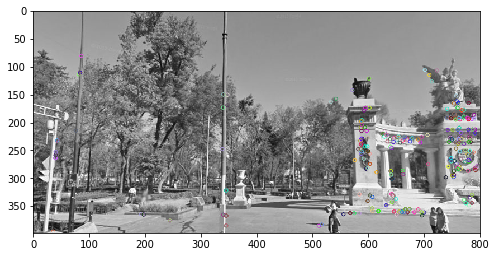

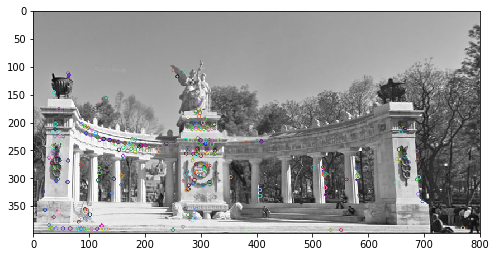

In [197]:
plt.figure(figsize = (8, 8))
a = cv2.drawKeypoints(image1_gray, image1_putative, None)
plt.imshow(a)

plt.figure(figsize = (8, 8))
b = cv2.drawKeypoints(image2_gray, image2_putative, None)
plt.imshow(b)

In [216]:
#RANSAC implementation
#Step 6
N = 1500 #1200 steps of RANSAC until we find the best homogrpahy
num_inliers_prev = 0 #Maximum number of inliers
threshold = 5 #Threshold to count as inlier 
count_initial_matches = 4 #No. of initial matches 

#Writing matches in homogeneous coordinates
p1_3D = np.array([[(putative_image1[ii].pt)[0], (putative_image1[ii].pt)[1], 1] for ii in range(len(putative_image1))]) 
p2_3D = np.array([[(putative_image2[ii].pt)[1], (putative_image2[ii].pt)[0], 1] for ii in range(len(putative_image2))]) 

for n in range(N): #Running the RANSAC loop for N iterations 
    residual_now = []
    residual_total = []
    num_inliers_now = 0
    inliers_now = []
    
    #Selecting 4 random matches from putative matches 
    initial_matches = np.random.randint(0, count_putative, count_initial_matches)   
    
    zero_vector = np.zeros((1,3)) #A 3D vector of zeros
    
    for i in range(len(initial_matches)):
        row1 = np.hstack((zero_vector, p1_3D[initial_matches[i]].reshape(1,-1), (-1*p2_3D[initial_matches[i]][1]*p1_3D[initial_matches[i]]).reshape(1,-1)))        
        row2 = np.hstack((p1_3D[initial_matches[i]].reshape(1,-1), zero_vector, (-1*p2_3D[initial_matches[i]][0]*p1_3D[initial_matches[i]]).reshape(1,-1)))
        row = np.vstack((row1,row2))

        if i==0:
            svd_matrix = row
        else:
            svd_matrix = np.vstack((svd_matrix, row))
     
    U, S, V = np.linalg.svd(svd_matrix)
    H = V[len(V)-1]
    H_now = H.reshape(3,3) 
   
    #Computing the number of inliers for each homography in each iteration
    for j in range(len(p1_3D)):
        trans = np.matmul(H_now, p1_3D[j])
        trans = trans/trans[-1]
        trans = trans[:-1] #Converting the point to non homogeneous coordinates 
        orig = p2_3D[j][:-1]
        resi = np.linalg.norm(orig-trans)**2
        residual_total.append(resi)
        if resi< threshold:
            residual_now.append(resi)
            num_inliers_now+=1
            inliers_now.append(j)
        
    if num_inliers_now > num_inliers_prev:
        num_inliers_prev = num_inliers_now
        H_prev = H_now
        inliers_prev = inliers_now
        residual_prev = residual_now

print ('Number of inliers = ', num_inliers_prev)
print ('Average residual of the inliers = ',  np.mean(residual_prev))

Number of inliers =  74
Average residual of the inliers =  1.156080547127797


In [217]:
#After RANSAC finds the best set of inliers
#Refitting the best homography for all inliers 

zero_vector = np.zeros((1,3)) #A 3D vector of zeros
residual_best = []
for i in range(len(inliers_prev)):
    row1 = np.hstack((zero_vector, p1_3D[inliers_prev[i]].reshape(1,-1), (-1*p2_3D[inliers_prev[i]][1]*p1_3D[inliers_prev[i]]).reshape(1,-1)))
    row2 = np.hstack((p1_3D[inliers_prev[i]].reshape(1,-1), zero_vector, (-1*p2_3D[inliers_prev[i]][0]*p1_3D[inliers_prev[i]]).reshape(1,-1)))
    row = np.vstack((row1,row2))

    if i==0:
        svd_matrix_i = row
    else:
        svd_matrix_i = np.vstack((svd_matrix_i, row))

U, S, V = np.linalg.svd(svd_matrix_i)

#Homography
H_best = V[-1]
H_best = H_best.reshape(3,3)

for j in range(len(p1_3D)):
    trans = np.matmul(H_best, p1_3D[j])
    trans = trans/trans[-1]
    trans = trans[:-1] #Converting the point to non homogeneous coordinates 
    orig = p2_3D[j][:-1]
    resi = np.linalg.norm(orig-trans)**2
    if resi< threshold:
        residual_best.append(resi)
        
print ('After fitting to all the inliers, the residual is = ', np.mean(residual_best))

After fitting to all the inliers, the residual is =  0.6885865279972374


### Plotting the inliers 

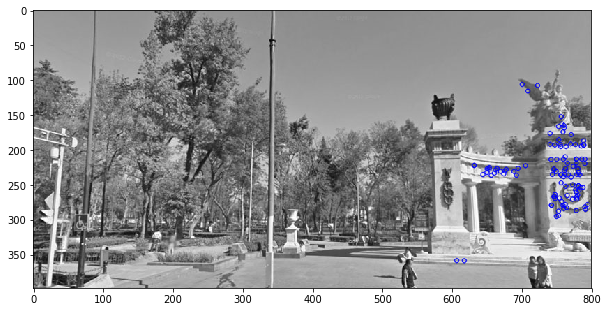

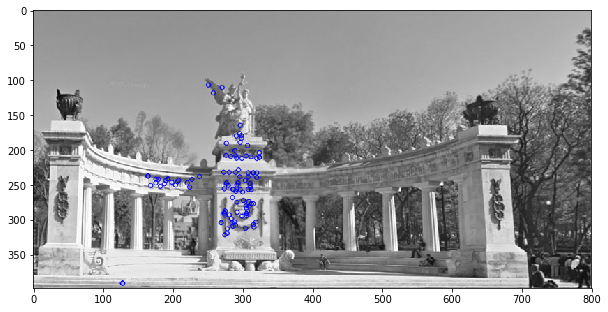

In [209]:
plt.figure(figsize = (10, 10))
a = cv2.drawKeypoints(image1_gray, np.array(image1_putative)[inliers_prev], None, (0, 0, 255))
plt.imshow(a)

plt.figure(figsize = (10, 10))
b = cv2.drawKeypoints(image2_gray, np.array(image2_putative)[inliers_prev], None, (0, 0, 255))
plt.imshow(b)

### Warping 

In [308]:
def warp_images2(image0, image1, transform):
    r, c = image0.shape[:2]
    # Note that transformations take coordinates in (x, y) format,
    # not (row, column), in order to be consistent with most literature
    corners = np.array([[c, r],
                        [0, c],
                        [r, 0],
                        [0, 0]])

    # Warp the image corners to their new positions
    warped_corners = transform(corners)

    # Find the extents of both the reference image and the warped
    # target image
    all_corners = np.vstack(( corners, warped_corners))

    
    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)

    output_shape = (corner_max - corner_min)
    output_shape = np.ceil(output_shape[::-1])

    offset = skimage.transform.SimilarityTransform(translation=-corner_min)

    image0_ = skimage.transform.warp(image0, offset.inverse, output_shape=output_shape, cval=-1)

    image1_ = skimage.transform.warp(image1, (transform + offset), output_shape=output_shape, cval=-1)

    image0_zeros = skimage.transform.warp(image0, offset.inverse, output_shape=output_shape, cval=0)

    image1_zeros = skimage.transform.warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=0)

    overlap = (image0_ != -1.0 ).astype(int) + (image1_ != -1.0).astype(int)
    overlap += (overlap < 1).astype(int)
    merged = (image0_zeros+image1_zeros)/overlap

    merged = np.where(image1_zeros>0, image1_zeros, merged)
    im = Image.fromarray((255*merged).astype('uint8'))#, mode = 'RGB')
    im.save('stitched_images.jpg')
    im.show()

In [243]:
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

In [307]:
#Step 7
transform = skimage.transform.ProjectiveTransform(H_best)
#warp_images2(image2.transpose(1,0,2), image1, transform)
warp_images2(image2_gray.T, image1_gray, transform)